# Chapter 12 - Custom Models and Training with TensorFlow

## Part II: Custom Models and Training

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

ERROR:root:Line magic function `%tensorflow_version` not found.
/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Customizing Models and Training Algorithms

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
housing = fetch_california_housing()

In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, 
                                               housing.target.reshape(-1, 1),
                                               random_state=42)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,
                                                     random_state=42)

In [6]:
scaler = StandardScaler()

In [7]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

## Custom Loss Function

### Huber loss:

In [8]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

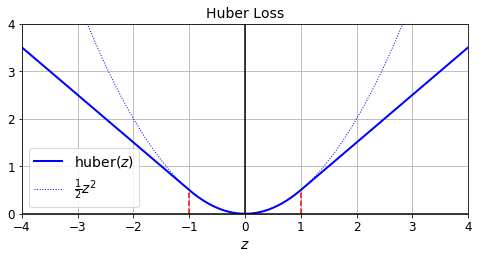

In [9]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), 'b-', linewidth=2, label='huber($z$)')
plt.plot(z, z**2 / 2, 'b:', linewidth=1, label=r'$\frac{1}{2}z^2$')
plt.plot([-1, -1], [0, huber_fn(0., -1.)], 'r--')
plt.plot([1, 1], [0, huber_fn(0., 1.)], 'r--')
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel('$z$')
plt.legend(fontsize=14)
plt.title('Huber Loss', fontsize=14)
plt.show()

In [10]:
input_shape = X_train.shape[1:]

In [11]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu',
                       kernel_initializer='lecun_normal',
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [12]:
model.compile(loss=huber_fn,
              optimizer='nadam',
              metrics=['mae'])

In [13]:
model.fit(X_train_scaled, y_train,
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 122us/sample - loss: 0.6229 - mae: 0.9934 - val_loss: 0.2816 - val_mae: 0.5838
Epoch 2/2
11610/11610 [==============================] - 1s 54us/sample - loss: 0.2190 - mae: 0.5173 - val_loss: 0.2365 - val_mae: 0.5216


## Saving/Loading Models with Custom Objects

In [14]:
model.save('my_model_with_a_custom_loss.h5')

In [15]:
model = keras.models.load_model('my_model_with_a_custom_loss.h5',
                                custom_objects={'huber_fn': huber_fn})

In [16]:
model.fit(X_train_scaled, y_train,
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 75us/sample - loss: 0.2048 - mae: 0.4976 - val_loss: 0.2126 - val_mae: 0.4968
Epoch 2/2
11610/11610 [==============================] - 0s 41us/sample - loss: 0.2002 - mae: 0.4911 - val_loss: 0.1978 - val_mae: 0.4826


Create a function that creates a configured loss function:

In [17]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn        

In [18]:
model.compile(loss=create_huber(2.0),
              optimizer='nadam',
              metrics=['mae'])

In [19]:
model.fit(X_train_scaled, y_train,
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 73us/sample - loss: 0.2224 - mae: 0.4894 - val_loss: 0.2410 - val_mae: 0.4816
Epoch 2/2
11610/11610 [==============================] - 1s 62us/sample - loss: 0.2180 - mae: 0.4845 - val_loss: 0.2252 - val_mae: 0.4751


In [20]:
model.save('my_model_with_a_custom_loss_threshold_2.h5')

In [21]:
model = keras.models.load_model('my_model_with_a_custom_loss_threshold_2.h5',
                                custom_objects={'huber_fn': create_huber(2.0)})

In [22]:
model.fit(X_train_scaled, y_train,
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 86us/sample - loss: 0.2145 - mae: 0.4794 - val_loss: 0.2060 - val_mae: 0.4654
Epoch 2/2
11610/11610 [==============================] - 1s 59us/sample - loss: 0.2118 - mae: 0.4767 - val_loss: 0.2022 - val_mae: 0.4564


In [23]:
class HuberLoss(keras.losses.Loss):
    
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
        
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

In [24]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu',
                       kernel_initializer='lecun_normal',
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [25]:
model.compile(loss=HuberLoss(2.0),
              optimizer='nadam',
              metrics=['mae'])

In [26]:
model.fit(X_train_scaled, y_train,
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 81us/sample - loss: 0.6982 - mae: 0.8827 - val_loss: 0.3284 - val_mae: 0.5434
Epoch 2/2
11610/11610 [==============================] - 1s 49us/sample - loss: 0.2399 - mae: 0.5068 - val_loss: 0.2621 - val_mae: 0.5015


In [27]:
model.save('my_model_with_a_custom_loss_class.h5')

In [ ]:
model = keras.models.load_model('my_model_with_a_custom_loss_class.h5',
                                custom_objects={'HuberLoss': HuberLoss})

In [29]:
model.loss.threshold

2.0

## Other Custom Functions

In [30]:
keras.backend.clear_session()

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

### Custom Activation Function:

In [32]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

### Custom Initializer:

In [33]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

### Custom Regularizer:

In [34]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

### Custom Constraint:

In [35]:
def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [36]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [37]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu',
                       kernel_initializer='lecun_normal',
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_initializer=my_glorot_initializer,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights)
])

In [38]:
model.compile(loss='mse',
              optimizer='nadam',
              metrics=['mae'])

In [39]:
model.fit(X_train_scaled, y_train,
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 80us/sample - loss: 1.4943 - mae: 0.8850 - val_loss: 1.5203 - val_mae: 0.5619
Epoch 2/2
11610/11610 [==============================] - 1s 52us/sample - loss: 0.5918 - mae: 0.5268 - val_loss: 1.5022 - val_mae: 0.5096


In [40]:
model.save('my_model_with_many_custom_parts.h5')

In [41]:
model = keras.models.load_model('my_model_with_many_custom_parts.h5',
            custom_objects={
                'my_softplus': my_softplus,
                'my_glorot_initializer': my_glorot_initializer,
                'my_l1_regularizer': my_l1_regularizer,
                'my_positive_weights': my_positive_weights
            })

TypeError: my_glorot_initializer() missing 1 required positional argument: 'shape'

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    
    def __init__(self, factor):
        self.factor = factor
    
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    
    def get_config(self):
        return {'factor': self.factor}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu',
                       kernel_initializer='lecun_normal',
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_initializer=my_glorot_initializer,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights)
])

In [ ]:
model.compile(loss='mse',
              optimizer='nadam',
              metrics=['mae'])

In [ ]:
model.fit(X_train_scaled, y_train,
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.save('my_model_with_many_custom_parts.h5')

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

## Custom Metrics

In [ ]:
keras.backend.clear_session()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu',
                       kernel_initializer='lecun_normal',
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [42]:
model.compile(loss='mse',
              optimizer='nadam',
              metrics=[create_huber(2.0)])

In [43]:
model.fit(X_train_scaled, y_train,
          epochs=2)

Epoch 1/2
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5220 - huber_fn: 0.2336
Epoch 2/2
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4993 - huber_fn: 0.2252


**Warning:** if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:

- the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the batch size (not the sum of weights, so the batch loss is not the weighted mean of the losses).
- the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [44]:
model.compile(loss=create_huber(2.0),
              optimizer='nadam',
              metrics=[create_huber(2.0)])

In [45]:
sample_weight = np.random.rand(len(y_train))

history = model.fit(X_train_scaled, y_train,
                    epochs=2,
                    sample_weight=sample_weight)

Epoch 1/2
11610/11610 [==============================] - 1s 58us/sample - loss: 0.1427 - huber_fn: 0.2222
Epoch 2/2
11610/11610 [==============================] - 0s 37us/sample - loss: 0.1377 - huber_fn: 0.2200


In [46]:
history.history['loss'][0], history.history['huber_fn'][0] * sample_weight.mean()

(0.14271765617231785, 0.1106913447000173)

## Streaming Metrics

In [47]:
precision = keras.metrics.Precision()

In [48]:
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: id=68088, shape=(), dtype=float32, numpy=0.8>

In [49]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: id=68138, shape=(), dtype=float32, numpy=0.5>

In [50]:
precision.result()

<tf.Tensor: id=68148, shape=(), dtype=float32, numpy=0.5>

In [51]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [52]:
precision.reset_states()

Create a streaming metric:

In [53]:
class HuberMetric(keras.metrics.Metric):
    
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.total = self.add_weight('total', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')
        
    def huber_fn(self, y_true, y_pred): # workaround
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
        
    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

In [54]:
m = HuberMetric(2.0)

In [55]:
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: id=68202, shape=(), dtype=float32, numpy=14.0>

In [56]:
m.result()

<tf.Tensor: id=68206, shape=(), dtype=float32, numpy=14.0>

In [57]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=14.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=1.0>]

In [58]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [59]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [60]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='selu',
                       kernel_initializer='lecun_normal',
                       input_shape=input_shape),
    keras.layers.Dense(1)
])

In [61]:
model.compile(loss=create_huber(2.0),
              optimizer='nadam',
              metrics=[HuberMetric(2.0)])

In [62]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), 
          epochs=2)

Epoch 1/2
11610/11610 [==============================] - 1s 58us/sample - loss: 0.8717 - huber_metric: 0.8717
Epoch 2/2
11610/11610 [==============================] - 0s 38us/sample - loss: 0.2567 - huber_metric: 0.2567


In [63]:
model.save("my_model_with_a_custom_metric.h5")

Looks like it works fine! More simply, we could have created the class like this:

In [64]:
class HuberMetric(keras.metrics.Mean):
    
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
        
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

This class handles shapes better, and it also supports sample weights.

In [65]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", 
                       kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [67]:
model.compile(loss=keras.losses.Huber(2.0), 
              optimizer="nadam",
              weighted_metrics=[HuberMetric(2.0)])

In [68]:
sample_weight = np.random.rand(len(y_train))

history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, 
                    sample_weight=sample_weight)

Epoch 1/2
11610/11610 [==============================] - 1s 68us/sample - loss: 0.4336 - HuberMetric: 0.8739
Epoch 2/2
11610/11610 [==============================] - 0s 36us/sample - loss: 0.1298 - HuberMetric: 0.2615


In [69]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.43364625671472556, 0.43364639481949674)

In [70]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [71]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
11610/11610 [==============================] - 0s 38us/sample - loss: 0.2378 - HuberMetric: 0.2378
Epoch 2/2
11610/11610 [==============================] - 0s 37us/sample - loss: 0.2279 - HuberMetric: 0.2279


**Warning:** In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see TF issue #38150). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the HuberMetric.

In [72]:
model.metrics[-1].threshold

2.0

## Custom Layers

In [73]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [74]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: id=88116, shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000):

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu',
                       input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])

In [77]:
model.compile(loss='mse',
              optimizer='nadam')

In [78]:
model.fit(X_train_scaled, y_train,
          epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11610/11610 [==============================] - 1s 64us/sample - loss: 13681365654862.8613 - val_loss: inf
Epoch 2/5
11610/11610 [==============================] - 1s 51us/sample - loss: 493578.6405 - val_loss: inf
Epoch 3/5
11610/11610 [==============================] - 1s 47us/sample - loss: 274951.7519 - val_loss: inf
Epoch 4/5
11610/11610 [==============================] - 1s 48us/sample - loss: 129439.4402 - val_loss: inf
Epoch 5/5
11610/11610 [==============================] - 1s 46us/sample - loss: 72170.3607 - val_loss: inf


In [79]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 18us/sample - loss: 1728.5436


1728.5435571418252

Create a subclass of the `keras.layers.Layer` class to implement a simplified version of the `Dense` layer:

In [80]:
class MyDense(keras.layers.Layer):
    
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=[batch_input_shape[-1], self.units],
            initializer='glorot_normal')
        self.bias = self.add_weight(
            name='bias',
            shape=[self.units],
            initializer='zeros')
        super().build(batch_input_shape) # must be here
        
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                'units': self.units,
                'activation': keras.activations.serialize(self.activation)}

In [81]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [82]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", 
            input_shape=input_shape),
    MyDense(1)
])

In [83]:
model.compile(loss="mse", 
              optimizer="nadam")

In [84]:
model.fit(X_train_scaled, y_train, 
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 73us/sample - loss: 2.2287 - val_loss: 0.8403
Epoch 2/2
11610/11610 [==============================] - 1s 49us/sample - loss: 0.6441 - val_loss: 0.6282


In [85]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 21us/sample - loss: 0.5475


0.5475413522054983

In [86]:
model.save("my_model_with_a_custom_layer.h5")

In [87]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [88]:
class MyMultiLayer(keras.layers.Layer):
    
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2
    
    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [89]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])

In [91]:
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

Let's create a layer with a different behavior during training and testing:

In [92]:
class AddGaussianNoise(keras.layers.Layer):
    
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
        
    def call(self, X, training=True):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
    
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [93]:
model.compile(loss='mse',
              optimizer='nadam')

In [94]:
model.fit(X_train_scaled, y_train, 
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 74us/sample - loss: 0.4878 - val_loss: 0.5836
Epoch 2/2
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4226 - val_loss: 0.4909


In [95]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 18us/sample - loss: 0.4025


0.4024852337763291

## Custom Models

Let's implement a custom `ResidualBlock`:

In [96]:
X_new_scaled = X_test_scaled

In [97]:
class ResidualBlock(keras.layers.Layer):
    
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons,
                                          activation='elu',
                                          kernel_initializer='he_normal') for _ in range(n_layers)]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [98]:
class ResidualRegressor(keras.models.Model):
    
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation='elu',
                                          kernel_initializer='he_normal')
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)
        
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [99]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [100]:
model = ResidualRegressor(1)

In [101]:
model.compile(loss='mse',
              optimizer='nadam',
              metrics=['accuracy'])

In [102]:
history = model.fit(X_train_scaled, y_train,
                    epochs=5)

Epoch 1/5
11610/11610 [==============================] - 1s 127us/sample - loss: 7.5186 - accuracy: 0.0019
Epoch 2/5
11610/11610 [==============================] - 1s 69us/sample - loss: 1.2075 - accuracy: 0.0023
Epoch 3/5
11610/11610 [==============================] - 1s 73us/sample - loss: 0.9630 - accuracy: 0.0026
Epoch 4/5
11610/11610 [==============================] - 1s 72us/sample - loss: 1.1591 - accuracy: 0.0027
Epoch 5/5
11610/11610 [==============================] - 1s 67us/sample - loss: 0.6449 - accuracy: 0.0028


In [103]:
score = model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 31us/sample - loss: 0.5202 - accuracy: 0.0017


In [104]:
y_pred = model.predict(X_new_scaled)

In [105]:
model.save_weights('my_custom_model.ckpt')

## Loss and Metrics based on Model Internals

Let's build a custom regression MLP model composed of a stack of five hiddent layers plus an output layer:

In [106]:
class ReconstructingRegressor(keras.models.Model):
    
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        
    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)
        
    def call(self, inputs, training=True):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - loss))
        self.add_loss(0.05 * recon_loss)
        return self.out(Z)

In [107]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [108]:
model = ReconstructingRegressor(1)

In [109]:
model.compile(loss='mse',
              optimizer='nadam')

In [ ]:
history = model.fit(X_train_scaled, y_train, 
                    epochs=2)

In [ ]:
y_pred = model.predict(X_test_scaled)

## Computing Gradients with Autodiff

Let's first consider a simple toy function:

In [112]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

$$ f(w_1, w_2) = 3w_1^2 + 2w_1w_2 $$

By approximation:

In [113]:
w1, w2 = 5, 3
eps = 1e-6

In [114]:
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [115]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

By autodiff:

In [116]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)

In [117]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

In [118]:
gradients = tape.gradient(z, [w1, w2])

In [119]:
gradients

[<tf.Tensor: id=138861, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=138832, shape=(), dtype=float32, numpy=10.0>]

The tape is automatically erased immediately after you call its `gradient()` method, so you will get an exception if you try to call `gradient()` twice:

In [120]:
with tf.GradientTape as tape:
    z = f(w1, w2)

AttributeError: __enter__

In [121]:
dz_dw1 = tape.gradient(z, w1) # => tensor 36.0
dz_dw2 = tape.gradient(z, w2) # RuntimeError!

RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.

In [122]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

In [123]:
dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now
del tape

In [124]:
dz_dw1, dz_dw2

(<tf.Tensor: id=138906, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=138909, shape=(), dtype=float32, numpy=10.0>)

By default, the tape will only track operations involving variables, so if you try to compute the gradient of `z` with regard to anything other than a variable, the result will be `None`:

In [125]:
c1, c2 = tf.constant(5.), tf.constant(3.)

In [126]:
with tf.GradientTape() as tape:
    z = f(c1, c2)

In [127]:
gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

However, you can force the tape to watch any tensors you like, to record every operation that involves them. You can then compute gradients with regard to these tensors, as if they were variables:

In [128]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

In [129]:
gradients = tape.gradient(z, [c1, c2])

In [130]:
gradients

[<tf.Tensor: id=138989, shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: id=138960, shape=(), dtype=float32, numpy=10.0>]

In some cases you may want to stop gradients from backpropagating through some part of your neural network. To do this, you must use the `tf.stop_gradient()` function:

In [131]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

In [132]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

In [133]:
gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: id=139020, shape=(), dtype=float32, numpy=30.0>, None]

Finally, you may occasionally run into some numerical issues when computing gradients.

For example, if you compute the gradients of the `my_softplus()` function for large inputs, the result will be `NaN`:

In [134]:
x = tf.Variable([100.])

In [135]:
with tf.GradientTape() as tape:
    z = my_softplus(x)

In [136]:
tape.gradient(z, [x])

[<tf.Tensor: id=139060, shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [137]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

In [138]:
tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: id=139185, shape=(), dtype=float32, numpy=90.0>, None]

In [139]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

In [140]:
tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]),
              axis=0)
del tape

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [141]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])

In [142]:
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]

AttributeError: 'NoneType' object has no attribute '_id'

In [143]:
del hessian_tape

In [144]:
@tf.custom_gradient

def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [145]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [146]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: id=139405, shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: id=139429, shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## Custom Training Loops

In [147]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

First, let’s build a simple model. No need to compile it, since we will handle the training loop manually:

In [148]:
l2_reg = keras.regularizers.l2(0.05)

In [149]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='elu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1,
                       kernel_regularizer=l2_reg)
])

Next, let’s create a tiny function that will randomly sample a batch of instances from the training set:

In [150]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

Let’s also define a function that will display the training status, including the number of steps, the total number of steps, the mean loss since the start of the epoch (i.e., we will use the `Mean` metric to compute it), and other metrics:

In [151]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = ' - '.join(['{}: {:.4f}'.format(m.name, m.result()) 
                          for m in [loss] + (metrics or [])])
    end = '' if iteration < total else '\n'
    print('\r{}/{} - '.format(iteration, total) + metrics, end=end)

In [152]:
import time

mean_loss = keras.metrics.Mean(name='loss')
mean_square = keras.metrics.Mean(name='mean_square')

for i in range(1, 50+1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [153]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [154]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [155]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [156]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")

for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [157]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

With that, let’s get down to business! First, we need to define some hyperparameters and choose the optimizer, the loss function, and the metrics (just the MAE in this example):

In [158]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [159]:
for epoch in range(1, n_epochs + 1):
    print('Epoch {}/{}'.format(epoch, n_epochs))
    
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.4384 - mean_absolute_error: 0.58792
Epoch 2/5
11610/11610 [==============================] - mean: 0.6721 - mean_absolute_error: 0.5281
Epoch 3/5
11610/11610 [==============================] - mean: 0.6342 - mean_absolute_error: 0.5185
Epoch 4/5
11610/11610 [==============================] - mean: 0.6394 - mean_absolute_error: 0.5187
Epoch 5/5
11610/11610 [==============================] - mean: 0.6434 - mean_absolute_error: 0.5216


In [160]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

To run this cell, please install tqdm, ipywidgets and restart Jupyter


## TensorFlow Functions

In [161]:
def cube(x):
    return x ** 3

In [162]:
cube(2)

8

In [163]:
cube(tf.constant(2.0))

<tf.Tensor: id=804710, shape=(), dtype=float32, numpy=8.0>

TensorFlow Function:

In [164]:
tf_cube = tf.function(cube)
tf_cube

In [165]:
tf_cube(2)

<tf.Tensor: id=804717, shape=(), dtype=int32, numpy=8>

In [166]:
tf_cube(tf.constant(2.0))

<tf.Tensor: id=804727, shape=(), dtype=float32, numpy=8.0>

## TF Functions and Concrete Functions

In [167]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [168]:
concrete_function(tf.constant(2.0))

<tf.Tensor: id=804732, shape=(), dtype=float32, numpy=8.0>

In [169]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

## Exploring Function Definitions and Graphs

In [170]:
concrete_function.graph

In [171]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [172]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [173]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [174]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [175]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [176]:
concrete_function.function_def.signature

name: "__inference_cube_804726"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

## How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [177]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [178]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [179]:
result

<tf.Tensor: id=804745, shape=(), dtype=float32, numpy=8.0>

In [180]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # no trace

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(None, 2), dtype=float32)


It is also possible to specify a particular input signature:

In [181]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [182]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [183]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [184]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])

try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature: inputs ((<tf.Tensor: id=804812, shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.7413678 , 0.62854624],
        [0.01738465, 0.3431449 ]],

       [[0.51063764, 0.3777541 ],
        [0.07321596, 0.02137029]]], dtype=float32)>,)), input_signature ((TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None),))


## Using Autograph To Capture Control Flow

A "static" `for` loop using `range()`:

In [185]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [186]:
add_10(tf.constant(5))

<tf.Tensor: id=804841, shape=(), dtype=int32, numpy=15>

In [187]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=Add>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=Add>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=Add>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=Add>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=Add>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=Add>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=Add>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=Add>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=Add>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [188]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [189]:
add_10(tf.constant(5))

<tf.Tensor: id=804887, shape=(), dtype=int32, numpy=15>

In [190]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=While>,
 <tf.Operation 'while/Identity' type=Identity>,
 <tf.Operation 'while/Identity_1' type=Identity>,
 <tf.Operation 'while/Identity_2' type=Identity>,
 <tf.Operation 'while/Identity_3' type=Identity>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [191]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [192]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=While>,
 <tf.Operation 'while/Identity' type=Identity>,
 <tf.Operation 'while/Identity_1' type=Identity>,
 <tf.Operation 'while/Identity_2' type=Identity>,
 <tf.Operation 'while/Identity_3' type=Identity>,
 <tf.Operation 'while/Identity_4' type=Identity>,
 <tf.Operation 'Identity' type=Identity>]

## Handling Variables and Other Resources in TF Functions

In [193]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [194]:
increment(counter)
increment(counter)

<tf.Tensor: id=804969, shape=(), dtype=int32, numpy=2>

In [195]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [196]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [197]:
increment()
increment()

<tf.Tensor: id=804987, shape=(), dtype=int32, numpy=2>

In [198]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [199]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [200]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: id=805005, shape=(), dtype=int32, numpy=2>

In [201]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

tf.autograph.to_code(add_10.python_function)

"from __future__ import print_function\n\ndef tf__add_10(x):\n  try:\n    with ag__.function_scope('add_10'):\n      do_return = False\n      retval_ = None\n\n      def loop_body(loop_vars, x_1):\n        with ag__.function_scope('loop_body'):\n          i = loop_vars\n          x_1 += 1\n          return x_1,\n      x, = ag__.for_stmt(ag__.converted_call('range', tf, ag__.ConversionOptions(recursive=True, verbose=0, strip_decorators=(ag__.convert, ag__.do_not_convert, ag__.converted_call), force_conversion=False, optional_features=ag__.Feature.ALL, internal_convert_user_code=True), (10,), {}), None, loop_body, (x,))\n      do_return = True\n      retval_ = x\n      return retval_\n  except:\n    ag__.rewrite_graph_construction_error(ag_source_map__)\n\n\n\ntf__add_10.autograph_info__ = {}\n"

In [202]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [203]:
display_tf_code(add_10)

```python
from __future__ import print_function

def tf__add_10(x):
  try:
    with ag__.function_scope('add_10'):
      do_return = False
      retval_ = None

      def loop_body(loop_vars, x_1):
        with ag__.function_scope('loop_body'):
          i = loop_vars
          x_1 += 1
          return x_1,
      x, = ag__.for_stmt(ag__.converted_call('range', tf, ag__.ConversionOptions(recursive=True, verbose=0, strip_decorators=(ag__.convert, ag__.do_not_convert, ag__.converted_call), force_conversion=False, optional_features=ag__.Feature.ALL, internal_convert_user_code=True), (10,), {}), None, loop_body, (x,))
      do_return = True
      retval_ = x
      return retval_
  except:
    ag__.rewrite_graph_construction_error(ag_source_map__)



tf__add_10.autograph_info__ = {}

```

## Using TF Functions with tf.keras (or Not)

By default, tf.keras will automatically convert your custom code into TF Functions, no need to use `tf.function()`:

In [204]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [205]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [206]:
# Custom layer
class MyDense(keras.layers.Layer):
    
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [207]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [208]:
# Custom model
class MyModel(keras.models.Model):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [209]:
model.compile(loss=my_mse, 
              optimizer="nadam", 
              metrics=[my_mae])

In [210]:
model.fit(X_train_scaled, y_train, 
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing metric my_mae()
Tracing metric my_mae()
Tracing loss my_mse()
Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 77us/sample - loss: 1.3164 - my_mae: 0.7935 - val_loss: 0.5629 - val_my_mae: 0.4915
Epoch 2/2
11610/11610 [==============================] - 1s 54us/sample - loss: 0.4434 - my_mae: 0.4779 - val_loss: 0.4852 - val_my_mae: 0.4528


In [211]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: 0.4235 - my_mae: 0.4608


[0.42349057040473287, 0.46075788]

You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, **kwargs)` in the model's constructor):

In [212]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [213]:
model = MyModel(dynamic=True)

In [214]:
model.compile(loss=my_mse, 
              optimizer="nadam", 
              metrics=[my_mae])

In [215]:
model.fit(X_train_scaled, y_train, 
          epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
   32/11610 [..............................] - ETA: 20s - loss: 7.0258 - my_mae: 2.3381Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
  160/11610 [..............................] - ETA: 8s - loss: 5.9069 - my_mae: 2.1625 Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metr

Tracing metric my_mae()
 1568/11610 [===>..........................] - ETA: 7s - loss: 5.1026 - my_mae: 1.9734Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 1632/11610 [===>..........................] - ETA: 7s - loss: 5.0269 - my_mae: 1.9550Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 1696/11610 [===>..........................] - ETA: 7s - loss: 4.9305 - my_mae: 1.9304Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Traci

Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 3136/11610 [=======>......................] - ETA: 6s - loss: 3.3092 - my_mae: 1.4466Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 3232/11610 [=======>......................] - ETA: 6s - loss: 3.2261 - my_mae: 1.4198Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()


 4640/11610 [==========>...................] - ETA: 5s - loss: 2.4578 - my_mae: 1.1758Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 4736/11610 [===========>..................] - ETA: 4s - loss: 2.4250 - my_mae: 1.1642Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


 6208/11610 [===============>..............] - ETA: 3s - loss: 1.9839 - my_mae: 1.0176Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 6304/11610 [===============>..............] - ETA: 3s - loss: 1.9728 - my_mae: 1.0129Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 7808/11610 [===================>..........] - ETA: 2s - loss: 1.6999 - my_mae: 0.9241Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 7904/11610 [===================>..........] - ETA: 2s - loss: 1.6910 - my_mae: 0.9213Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()


Tracing metric my_mae()
 9312/11610 [=======================>......] - ETA: 1s - loss: 1.5161 - my_mae: 0.8623Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 9408/11610 [=======================>......] - ETA: 1s - loss: 1.5064 - my_mae: 0.8588Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 9472/11610 [=======================>......] - ETA: 1s - loss: 1.4999 - my_mae: 0.8568Tracing MyModel.call()
Traci

Tracing metric my_mae()
10848/11610 [===========================>..] - ETA: 0s - loss: 1.3713 - my_mae: 0.8119Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
10944/11610 [===========================>..] - ETA: 0s - loss: 1.3634 - my_mae: 0.8095Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
11008/11610 [===========================>..] - ETA: 0s - loss: 1.3580 - my_mae: 0.8077Tracing MyModel.call()
Traci

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyD

Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing los

Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
  128/11610 [..............................] - ETA: 7s - loss: 0.5761 - my_mae: 0.5342Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
  224/11610 [..............................] - ETA: 8s - loss: 0.5032 - my_mae: 0.5126Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()


Tracing metric my_mae()
 1632/11610 [===>..........................] - ETA: 6s - loss: 0.4482 - my_mae: 0.4938Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 1728/11610 [===>..........................] - ETA: 6s - loss: 0.4473 - my_mae: 0.4954Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 1792/11610 [===>..........................] - ETA: 6s - loss: 0.4462 - my_mae: 0.4950Tracing MyModel.call()
Traci

Tracing metric my_mae()
 3200/11610 [=======>......................] - ETA: 6s - loss: 0.4676 - my_mae: 0.5019Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 3296/11610 [=======>......................] - ETA: 5s - loss: 0.4656 - my_mae: 0.5007Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()


Tracing metric my_mae()
 4768/11610 [===========>..................] - ETA: 4s - loss: 0.4634 - my_mae: 0.4944Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 4864/11610 [===========>..................] - ETA: 4s - loss: 0.4646 - my_mae: 0.4954Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()


 6304/11610 [===============>..............] - ETA: 3s - loss: 0.4541 - my_mae: 0.4889Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 6368/11610 [===============>..............] - ETA: 3s - loss: 0.4543 - my_mae: 0.4893Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 6464/11610 [===============>..............] - ETA: 3s - loss: 0.4549 - my_mae: 0.4894Tracing MyModel.call()
Tracing MyDense.call()
Tracin

Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 7904/11610 [===================>..........] - ETA: 2s - loss: 0.4558 - my_mae: 0.4875Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 8000/11610 [===================>..........] - ETA: 2s - loss: 0.4563 - my_mae: 0.4875Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()


 9408/11610 [=======================>......] - ETA: 1s - loss: 0.4499 - my_mae: 0.4837Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 9472/11610 [=======================>......] - ETA: 1s - loss: 0.4503 - my_mae: 0.4838Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
 9536/11610 [=======================>......] - ETA: 1s - loss: 0.4493 - my_mae: 0.4833Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracin

Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
10944/11610 [===========================>..] - ETA: 0s - loss: 0.4456 - my_mae: 0.4801Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
11008/11610 [===========================>..] - ETA: 0s - loss: 0.4446 - my_mae: 0.4797Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
11072/11610 [===========================>..] - ETA: 0s - loss: 0.4436 - my_mae: 0.4792Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing

Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metr

Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyD

In [216]:
model.evaluate(X_test_scaled, y_test)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
  32/5160 [..............................] - ETA: 1s - loss: 0.4531 - my_mae: 0.5263Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.cal

1760/5160 [=========>....................] - ETA: 0s - loss: 0.4423 - my_mae: 0.4632Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
1856/5160 [=========>....................] - ETA: 0s - loss: 0.4349 - my_mae: 0.4616Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Trac

3488/5160 [===================>..........] - ETA: 0s - loss: 0.4283 - my_mae: 0.4608Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
3680/5160 [====================>.........] - ETA: 0s - loss: 0.4266 - my_mae: 0.4605Trac

[0.41954182115969835, 0.45391732]

Alternatively, you can compile a model with `run_eagerly=True`:

In [217]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [218]:
model = MyModel()

In [219]:
model.compile(loss=my_mse, 
              optimizer="nadam", 
              metrics=[my_mae], 
              run_eagerly=True)

In [220]:
model.fit(X_train_scaled[:64], y_train[:64], 
          epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


In [221]:
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.508231163024902, 2.056763]

## Custom Optimizers

Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:

In [222]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [223]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [224]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])

In [225]:
model.compile(loss="mse", 
              optimizer=MyMomentumOptimizer())

In [226]:
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
11610/11610 [==============================] - 0s 41us/sample - loss: 3.8083
Epoch 2/5
11610/11610 [==============================] - 0s 33us/sample - loss: 1.4868
Epoch 3/5
11610/11610 [==============================] - 0s 27us/sample - loss: 0.9177
Epoch 4/5
11610/11610 [==============================] - 0s 30us/sample - loss: 0.7591
Epoch 5/5
11610/11610 [==============================] - 0s 28us/sample - loss: 0.70490s - loss: 0.725 - ETA: 0s - loss: 0.
